In [ ]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle

!rm -r sample_data
!kaggle competitions download -c jpx-tokyo-stock-exchange-prediction
!unzip ./jpx-tokyo-stock-exchange-prediction.zip -d jpx-tokyo-stock-exchange-prediction

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [43]:
class TSDataset(Dataset):
  def __init__(self, df, seq_len=128, padding_token=0, vec_dates=True, normalize=True):
    self.vec_dates = vec_dates
    
    self.df = df
    self.indices = []
    self.seq_len = seq_len
    self.normalize = normalize
    self.padding_token = padding_token
    
    #Creating indices
    start = 0
    for _ in range(-(len(self.df) // -self.seq_len)):
      self.indices.append((start, start+self.seq_len))
      start+=self.seq_len
    
    #fixing non-perfect intervals, --in place
    idx = 0
    while idx<len(self.indices):
      start, end = self.indices[idx]
      intervals = self.df[start:end]['SecuritiesCode'].value_counts(sort=False).values
      if len(intervals) != 1:
        self.indices = self.indices[:idx] + [(start, start+intervals[0]), (start+intervals[0], end)] + self.indices[idx+1:]
        idx+=1
      idx+=1
  
  def __len__(self):
    return len(self.indices)
  
  def __getitem__(self, idx):
    start, end = self.indices[idx]
    seq_df = self.df[start:end]
    
    target = (seq_df['Target'].values[-1])

    sequence = np.expand_dims(seq_df['Close'].values, 1)
    if self.normalize:    #Normalizing
      sequence = (sequence - sequence.min())/(sequence.max() - sequence.min())
    
    if sequence.shape[0] != self.seq_len:    #Padding
     sequence = np.pad(sequence, pad_width=[(self.seq_len-sequence.shape[0], 0), (0, 0)], constant_values=self.padding_token, mode='constant')

    #careful here padding_mask shape shouldn't be the same as sequence's, it works now bc we're using only one feature
    padding_mask = (sequence == self.padding_token)
    if self.vec_dates:
      date_vec = np.concatenate([np.expand_dims(seq_df['Date'].dt.year.values, 1), 
                                 np.expand_dims(seq_df['Date'].dt.month.values, 1), 
                                 np.expand_dims(seq_df['Date'].dt.day.values, 1)], 
                                axis=1)
      date_vec = np.pad(date_vec, pad_width=[(self.seq_len-date_vec.shape[0], 0), (0, 0)], constant_values=self.padding_token, mode='constant')
      
      return {'sequence':sequence,
              'date':date_vec,
              'mask':padding_mask,
              'target':target}
    else:
      
      return {'sequence':sequence,
              'mask':padding_mask,
              'target':target}

In [5]:
class time2vec(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.w_linear = nn.Parameter(data=torch.rand(in_features, 1))
    self.b_linear = nn.Parameter(data=torch.rand(1))
    self.w_function = nn.Parameter(data=torch.rand(in_features, out_features-1))
    self.b_function = nn.Parameter(data=torch.rand(out_features-1))

    #maybe a bit more straightforward
    #self.linear_params = nn.Linear(in_features, 1, bias=True)
    #self.function_params = nn.Linear(in_features, out_features-1, bias=True)

    #initialize params?
    #nn.init.kaiming_normal_(self.w_linear)
    #nn.init.kaiming_normal_(self.b_linear)
    #nn.init.kaiming_normal_(self.w_function)
    #nn.init.kaiming_normal_(self.b_function)

  def forward(self, x):
    linear_out = torch.matmul(x, self.w_linear)+self.b_linear
    func_out = torch.sin(torch.matmul(x, self.w_function)+self.b_function)
    return torch.concat((linear_out, func_out), dim=-1)

In [6]:
class TSTransformer(nn.Module):
  def __init__(self, in_features, time_features=7, mlp_dim=1024, enc_layers=2, enc_heads=2, date_vec=True):
    super().__init__()
    self.date_vec = date_vec
    if date_vec:
      self.time2vec = time2vec(3, time_features)
    else:
      self.time2vec = time2vec(in_features, time_features)
    self.encoder_layer = nn.TransformerEncoderLayer(d_model=in_features+time_features, nhead=enc_heads, 
                                                    dropout=0, activation=F.gelu, batch_first=True, 
                                                    norm_first=True)
    self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=enc_layers)

    self.mlp = nn.Linear(in_features+time_features, mlp_dim)
    self.regressor = nn.Linear(mlp_dim, 1)

  def forward(self, in_forward):
    if self.date_vec:
      time_embeddings = self.time2vec(in_forward['date'].float())
    else:
      time_embeddings = self.time2vec(in_forward['sequence'].float())
    x = torch.concat((in_forward['sequence'].float(), time_embeddings), dim=-1)
    x = self.encoder(src=x, src_key_padding_mask=in_forward['mask'].squeeze(-1).float())

    x = F.relu(self.mlp(x))
    x = self.regressor(x)

    return x[:, -1, :] #returning only last seq element

In [7]:
seq_len = 128

padding_token = 0.0
missing_token = -1.0


dframe = pd.read_csv('jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv', parse_dates=['Date'])

stock_list = dframe.SecuritiesCode.unique()
dframe_1 = dframe.drop(['Open', 'High', 'Low', 'Volume', 'RowId', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag'], axis=1)
dframe_1 = dframe_1[~dframe_1['Close'].isnull()] #Getting rid of null values for this experiment
dframe_1 = dframe_1.sort_values(['SecuritiesCode', 'Date'], ascending=[True, True]).reset_index(drop=True)

In [67]:
dset = TSDataset(dframe_1, seq_len=128, vec_dates=False, normalize=True)
dloader = DataLoader(dset, batch_size=128, shuffle=False, num_workers=1)

train_batch = next(iter(dloader))
target = train_batch.pop('target')

#train_batch['sequence'].shape, train_batch['date'].shape, train_batch['mask'].shape, target.shape

In [72]:
####Overfitting a single batch ----On vector dates


#consider another criterion
#consider modifying model params
#May be a good idea to normalize the data -------done
#consider encoding the vector dates instead of the sequence ---------done
model = TSTransformer(in_features=1, time_features=7, date_vec=False)

crit = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr = 1e-5)

total_loss = []
for epoch in range(10):
  out = model(train_batch)
  loss = crit(out.squeeze(-1), target.float())
  loss.backward()
  optim.step()
  total_loss.append(loss.item())
  print(loss)

tensor(0.0080, grad_fn=<MseLossBackward0>)
tensor(0.0065, grad_fn=<MseLossBackward0>)
tensor(0.0052, grad_fn=<MseLossBackward0>)
tensor(0.0041, grad_fn=<MseLossBackward0>)
tensor(0.0032, grad_fn=<MseLossBackward0>)
tensor(0.0024, grad_fn=<MseLossBackward0>)
tensor(0.0019, grad_fn=<MseLossBackward0>)
tensor(0.0016, grad_fn=<MseLossBackward0>)
tensor(0.0015, grad_fn=<MseLossBackward0>)
tensor(0.0016, grad_fn=<MseLossBackward0>)


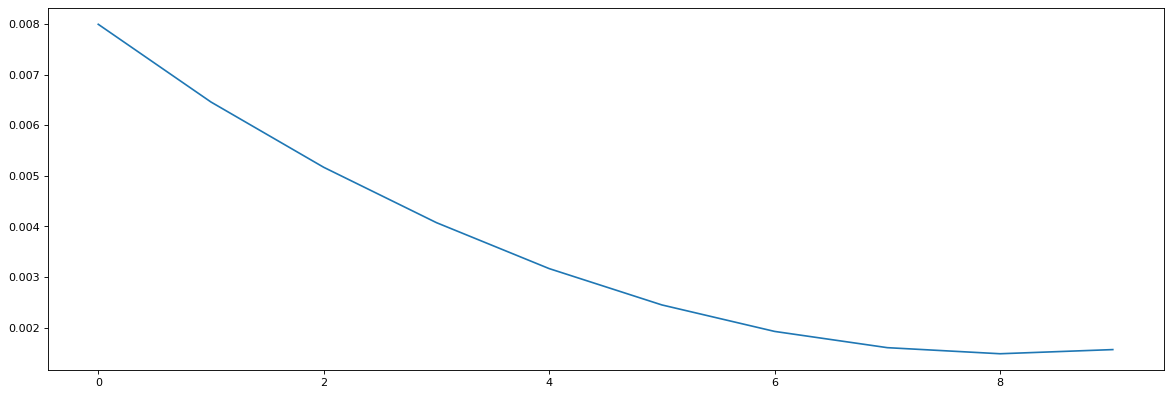

In [73]:
tensor_loss = torch.tensor(total_loss)

plt.figure(figsize=(18, 6), dpi=80)
plt.plot(tensor_loss.numpy())
plt.show()